一般線形モデルでMCMCをやってみるデモ

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pystan
import arviz

In [2]:
# 自動車の燃費や、シリンダーの数、重さ等をまとめたデータ

columns_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv("./input/auto-mpg.data", names=columns_names, na_values="?",
                 comment="\t", sep=" ", skipinitialspace=True)

df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


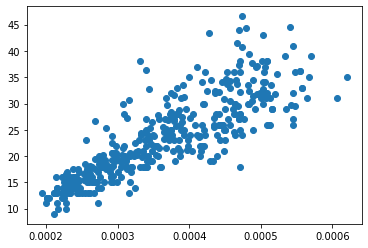

In [3]:
# 今回の目的変数は MPG(燃費)
# MPG は 重さの逆数(Weight_inv) に比例するのでは? という仮説のもとに解析を行う

df["Weight_inv"] = df["Weight"].apply(lambda x: 1/x)
plt.scatter(df["Weight_inv"], df["MPG"])

MPG ~ Normal( a*Wight^-1 + b, sigma)という仮定(モデル)でMCMCを行う

In [4]:
stan_model = """
// data ... 観測データを記述
data {
    int  N;     // data数
    real X[N];  // inputData、 (N,)のベクトル
    real Y[N];  // targetData、(N,)のベクトル
}

// parameters ... 推定対象のパラメータを記述 ここに書いてあるパラメーターが推定される
parameters {
    real a;
    real b;
    real<lower=0> sigma; // sigmaは分散なので非負
}

// model ... 仮定した統計モデルを記述
model {
    // すべてのデータに対して
    for (n in 1:N) {
        Y[n] ~ normal(a*X[n]+b, sigma);
    }
}
"""

In [5]:
# モデルのコンパイル
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4be073f72cdcb00558472a3c9a0769ca NOW.


In [6]:
# stan_modelで設計したデータを設定
stan_data = {
    "N": df.shape[0],
    "X": df["Weight_inv"],
    "Y": df["MPG"]
}

# iter: 　MCMC連鎖(チェーン)のサンプリング回数
# warmup: サンプリングの最初のどれだけを捨てるか( 連鎖(チェーン)の最初のほうの結果は不安定であるため )
# chains: MCMCの連鎖(チェーン)を何回実行するか
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=0)
print(fit)

Inference for Stan model: anon_model_4be073f72cdcb00558472a3c9a0769ca.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
a      6.6e4   56.42 2161.1  6.2e4  6.5e4  6.6e4   6.8e4  7.0e4   1467    1.0
b      -0.55    0.02   0.81  -2.11  -1.12  -0.53 -7.6e-3   1.05   1495    1.0
sigma   4.25  3.3e-3   0.15   3.97   4.15   4.25    4.35   4.57   2111    1.0
lp__  -772.7    0.03   1.22 -775.9 -773.3 -772.4  -771.8 -771.3   1452    1.0

Samples were drawn using NUTS at Thu Jan 27 08:18:57 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


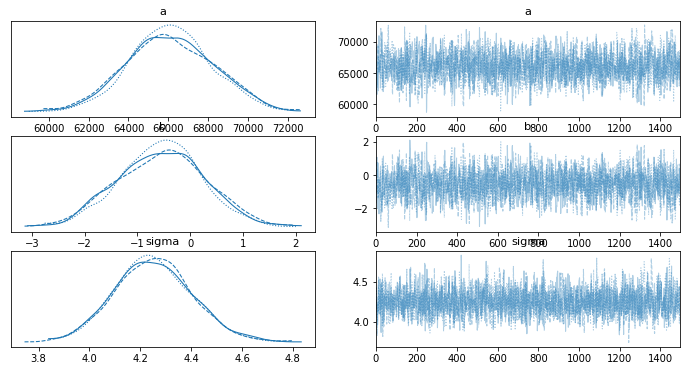

In [7]:
fig = arviz.plot_trace(fit)